In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import os
import copy
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


In [3]:
def initialize_model(num_classes):
    input_size = 224 
    use_pretrained = True
    
    model_ft = models.resnet50(pretrained=use_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    
    return model_ft, input_size

## Data Loading

With the input size from the model, we can now load the dataset

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

## Training
Next, let's make a helper function that trains the given model

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

In [7]:
num_classes = 5
batch_size = 16
shuffle_datasets = True
num_epochs = 50

data_dir = "/content/drive/MyDrive/Cervical Image Classification/separated-data"
save_dir = "/content/drive/MyDrive/Cervical Image Classification/weights"
os.makedirs(save_dir, exist_ok=True)

save_all_epochs = True

## Tying it all together - Training

In [8]:
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)

model, input_size = initialize_model(num_classes = num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.2788 Acc: 0.5104


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.9413 Acc: 0.6126

Epoch 2/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9701 Acc: 0.6647


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.6583 Acc: 0.5707

Epoch 3/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7683 Acc: 0.7181


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6297 Acc: 0.7435

Epoch 4/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.6869 Acc: 0.7582


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.0390 Acc: 0.7120

Epoch 5/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7046 Acc: 0.7493


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7587 Acc: 0.7382

Epoch 6/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5847 Acc: 0.7982


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6896 Acc: 0.7644

Epoch 7/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5233 Acc: 0.8042


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6591 Acc: 0.7958

Epoch 8/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5748 Acc: 0.7834


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7654 Acc: 0.7435

Epoch 9/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5270 Acc: 0.8027


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4318 Acc: 0.8848

Epoch 10/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5000 Acc: 0.8190


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8040 Acc: 0.7906

Epoch 11/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5209 Acc: 0.8101


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4224 Acc: 0.8901

Epoch 12/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4383 Acc: 0.8398


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3875 Acc: 0.8639

Epoch 13/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3323 Acc: 0.8709


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3639 Acc: 0.8691

Epoch 14/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3617 Acc: 0.8754


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4197 Acc: 0.8848

Epoch 15/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3757 Acc: 0.8680


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5038 Acc: 0.8482

Epoch 16/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3267 Acc: 0.9006


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3823 Acc: 0.8796

Epoch 17/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3966 Acc: 0.8650


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3188 Acc: 0.9162

Epoch 18/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3590 Acc: 0.8739


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4599 Acc: 0.8586

Epoch 19/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3069 Acc: 0.8843


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3659 Acc: 0.8743

Epoch 20/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3340 Acc: 0.8858


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3172 Acc: 0.9005

Epoch 21/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3794 Acc: 0.8709


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4608 Acc: 0.8691

Epoch 22/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3093 Acc: 0.8828


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6168 Acc: 0.7592

Epoch 23/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4060 Acc: 0.8591


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3278 Acc: 0.9005

Epoch 24/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3276 Acc: 0.8858


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3595 Acc: 0.8691

Epoch 25/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3408 Acc: 0.8754


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3337 Acc: 0.8901

Epoch 26/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2547 Acc: 0.9125


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3403 Acc: 0.9162

Epoch 27/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3365 Acc: 0.8783


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3279 Acc: 0.8743

Epoch 28/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2586 Acc: 0.9228


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2754 Acc: 0.9162

Epoch 29/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1658 Acc: 0.9377


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2954 Acc: 0.9005

Epoch 30/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2650 Acc: 0.9080


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3127 Acc: 0.8796

Epoch 31/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2375 Acc: 0.9154


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3271 Acc: 0.9110

Epoch 32/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2363 Acc: 0.9139


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4132 Acc: 0.8743

Epoch 33/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2127 Acc: 0.9199


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8420 Acc: 0.7958

Epoch 34/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3231 Acc: 0.8961


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3106 Acc: 0.9110

Epoch 35/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2149 Acc: 0.9214


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3868 Acc: 0.8796

Epoch 36/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2625 Acc: 0.9214


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3679 Acc: 0.8901

Epoch 37/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1649 Acc: 0.9421


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3276 Acc: 0.8796

Epoch 38/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1637 Acc: 0.9436


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3147 Acc: 0.9058

Epoch 39/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1297 Acc: 0.9481


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4610 Acc: 0.8639

Epoch 40/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1308 Acc: 0.9555


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3475 Acc: 0.9058

Epoch 41/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2471 Acc: 0.9243


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4832 Acc: 0.8953

Epoch 42/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1695 Acc: 0.9436


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3749 Acc: 0.8901

Epoch 43/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1550 Acc: 0.9407


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3830 Acc: 0.8901

Epoch 44/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2126 Acc: 0.9347


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2824 Acc: 0.9110

Epoch 45/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1808 Acc: 0.9332


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3560 Acc: 0.9058

Epoch 46/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1133 Acc: 0.9614


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3238 Acc: 0.9058

Epoch 47/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1652 Acc: 0.9466


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4862 Acc: 0.8901

Epoch 48/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2356 Acc: 0.9154


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3877 Acc: 0.8953

Epoch 49/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1636 Acc: 0.9392


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2372 Acc: 0.9162

Epoch 50/50
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1291 Acc: 0.9570


100%|██████████| 12/12 [00:47<00:00,  3.97s/it]

val Loss: 0.2859 Acc: 0.8901

Training complete in 153m 18s
Best val Acc: 0.916230


In [11]:
# save pretrained weights
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/Cervical Image Classification/weights/resnet50")

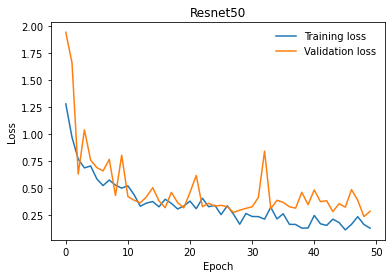

In [13]:
x = np.arange(0,50,1)
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

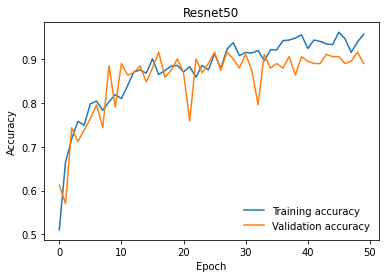

In [14]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [22]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)
            if generate_labels:
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            running_loss += loss.item() * inputs.size(0)
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [23]:
generate_validation_labels = True
data_dir = '/content/drive/MyDrive/Cervical Image Classification/separated-data'
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 5)

epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 5)

100%|██████████| 7/7 [00:31<00:00,  4.46s/it]


In [24]:
top1_acc

0.8514851485148515

# Section 5: Confusion Matrix

In [26]:
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}
running_top1_correct = 0
loader = dataloaders['test']
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_name[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


In [27]:
print(confusion_matrix)


print(epoch_top1_acc)

{'im_Dyskeratotic': [20, 0, 3, 0, 0], 'im_Koilocytotic': [1, 16, 6, 1, 1], 'im_Metaplastic': [1, 1, 26, 0, 0], 'im_Parabasal': [0, 0, 0, 12, 0], 'im_Superficial-Intermediate': [0, 0, 0, 0, 13]}
0.8613861386138614


In [28]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'im_Dyskeratotic': [0.8695652173913043, 0.0, 0.13043478260869565, 0.0, 0.0],
 'im_Koilocytotic': [0.04, 0.64, 0.24, 0.04, 0.04],
 'im_Metaplastic': [0.03571428571428571,
  0.03571428571428571,
  0.9285714285714286,
  0.0,
  0.0],
 'im_Parabasal': [0.0, 0.0, 0.0, 1.0, 0.0],
 'im_Superficial-Intermediate': [0.0, 0.0, 0.0, 0.0, 1.0]}

In [29]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

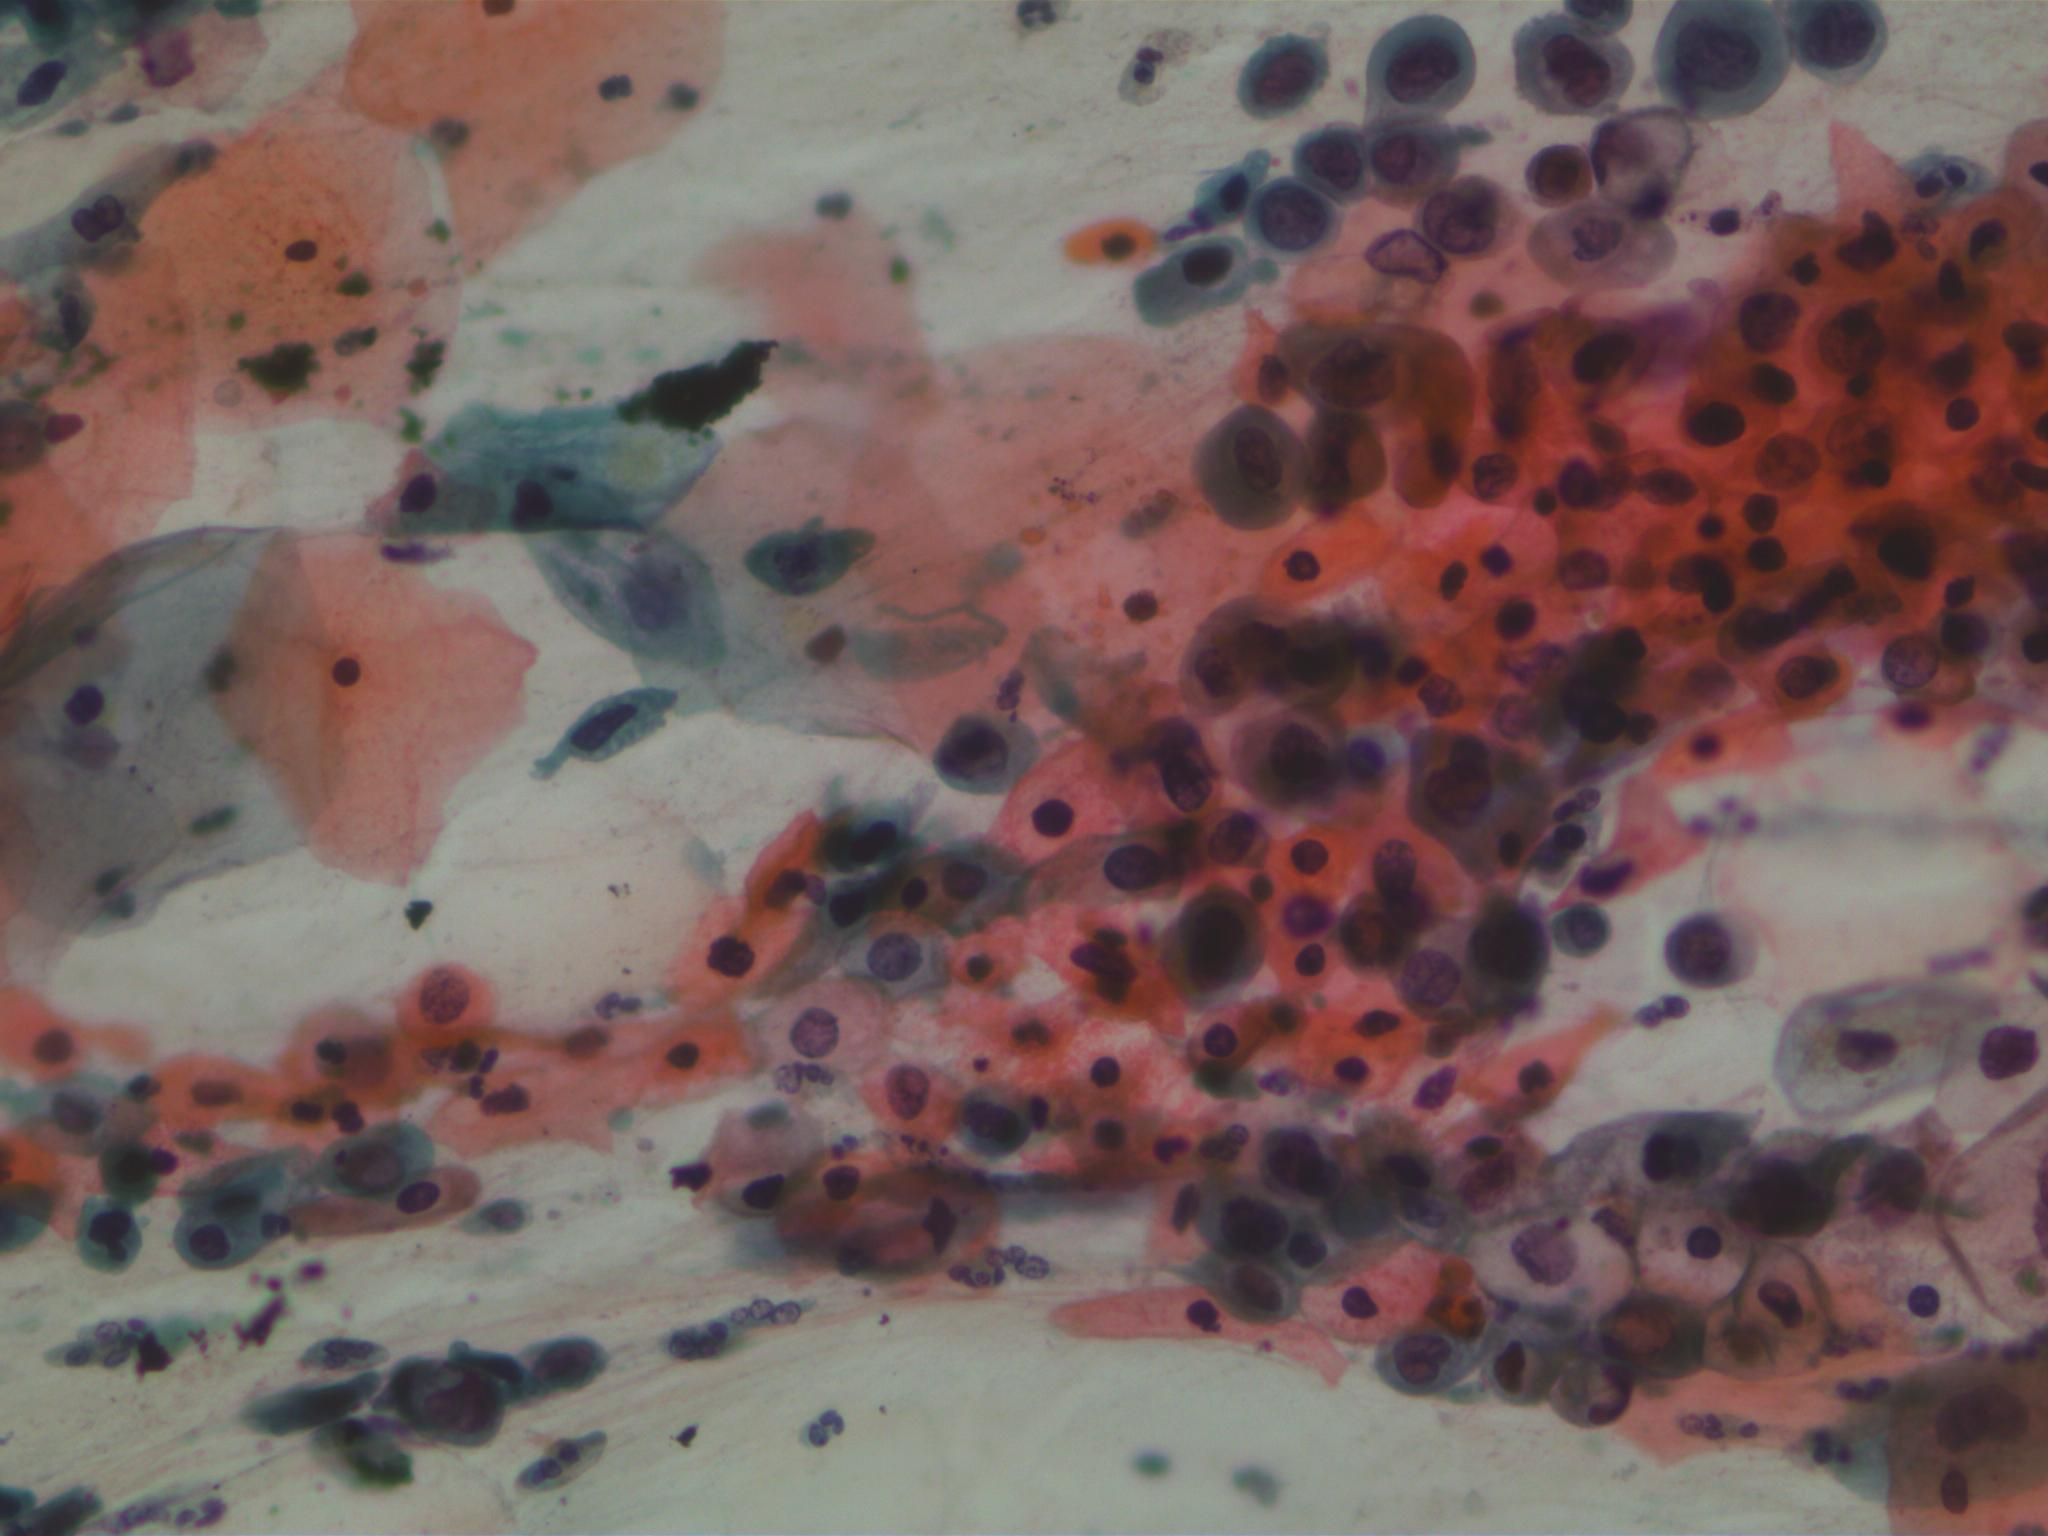

In [30]:
img0 = PIL.Image.open('/content/drive/MyDrive/Cervical Image Classification/separated-data/train/im_Dyskeratotic/002.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [34]:
def test_single_image(image):
    input_size = 224
    center_crop = transforms.Compose([
         transforms.Resize((input_size)),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    im = center_crop(image)
    im = im.to(device)
    out = model(im.unsqueeze(0)).squeeze()
    prob, categories = out.topk(5)
    sm = torch.nn.Softmax()
    probabilities = sm(prob) 
    for i in range(len(categories)):
        print(class_name[int(categories[i])] + ": " + str(float(probabilities[i])))

In [35]:
test_single_image(img0)

im_Dyskeratotic: 0.9895113110542297
im_Koilocytotic: 0.008370687253773212
im_Metaplastic: 0.0019391648238524795
im_Parabasal: 0.00015629494737368077
im_Superficial-Intermediate: 2.247883276140783e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.figure(figsize=(20,10))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

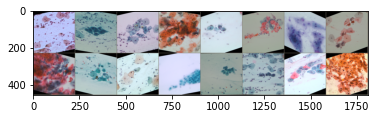

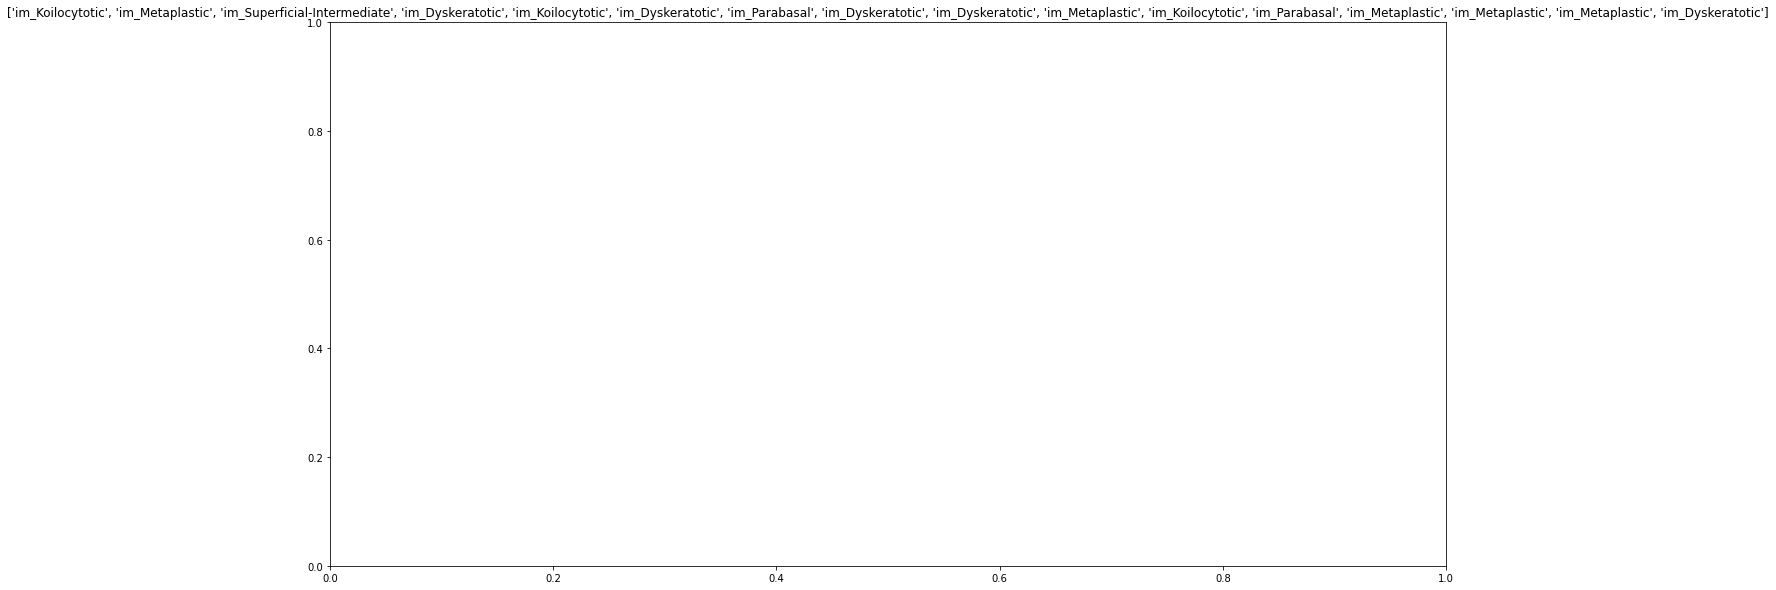

In [39]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_name[x] for x in classes])

In [40]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # impacts the autograd engine and deactivate it
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # iterate this batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, label: {}'.format(class_name[preds[j]], class_name[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

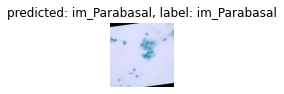

<Figure size 1440x720 with 0 Axes>

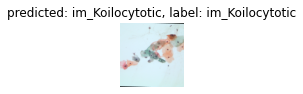

<Figure size 1440x720 with 0 Axes>

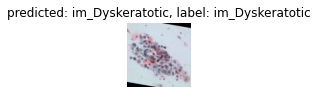

<Figure size 1440x720 with 0 Axes>

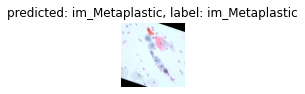

<Figure size 1440x720 with 0 Axes>

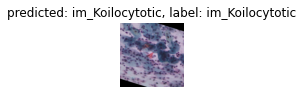

<Figure size 1440x720 with 0 Axes>

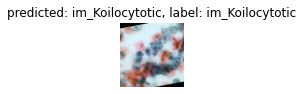

<Figure size 1440x720 with 0 Axes>

In [41]:
visualize_model(model)